<a href="https://colab.research.google.com/github/fiza-azam/Advanced-Computer-Vision/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

image input size = 128,128, 3 <br>
image mask size = 128, 128 <br>


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-p4y5mv77
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-p4y5mv77
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 7.0 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=97dc3e4276f516bf8093e4a511f50508d1f640aa8e2be8a7e1cefc3dcc46e190
  Stored in directory: /tmp/pip-ephem-wheel-cache-b5mxg5dr/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from keras.metrics import MeanIoU

#Data Exploration

(360, 480, 3)

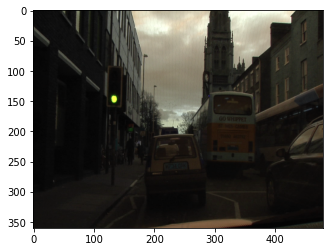

In [ ]:
#Image display and image size
img = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/images_prepped_train/0001TP_006690.png"
img = cv2.imread(img, cv2.IMREAD_COLOR)
plt.imshow(img)
img.shape

(360, 480)

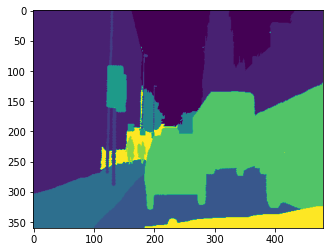

In [ ]:
#Image display and image size
mask = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/annotations_prepped_train/0001TP_006690.png"
mask = cv2.imread(mask, 0)
plt.imshow(mask)
mask.shape

In [ ]:
#unique classes
np.unique(mask)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11], dtype=uint8)

Image Size = (360, 480, 3) <br>
Mask Size = (360, 480) <br>
Unique Mask Classes = 12

#Data Augmentation

Perform Augmentation on Train Data

In [ ]:
def load_data(path):
    images = sorted(glob(os.path.join(path, "images_prepped_train/*")))
    masks = sorted(glob(os.path.join(path, "annotations_prepped_train/*")))
    return images, masks

In [ ]:
def load_annotated_data(path):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    return images, masks

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
def augment_data(images, masks, save_path, augment=True):
    W = 480
    H = 360

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:
          aug = CenterCrop(360, 360, p=1.0)
          augmented = aug(image=x, mask=y)
          x1 = augmented["image"]
          y1 = augmented["mask"]

          aug = GridDistortion(p=1.0)
          augmented = aug(image=x, mask=y)
          x2 = augmented['image']
          y2 = augmented['mask']

          aug = HorizontalFlip(p=1.0)
          augmented = aug(image=x, mask=y)
          x3 = augmented['image']
          y3 = augmented['mask']

          save_images = [x, x1, x2, x3]
          save_masks =  [y, y1, y2, y3]

        else:
          save_images = [x]
          save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"
                

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

In [ ]:
if __name__ == "__main__":
    """ Loading original images and masks. """
    path = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/"
    images, masks = load_data(path)
    print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")

    """ Creating Augmentation folders. """
    create_dir("/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/images")
    create_dir("/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/masks") 

    save_path = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data"
    augment_data(images, masks, save_path, augment=True)

Original Images: 367 - Original Masks: 367


100%|██████████| 367/367 [03:35<00:00,  1.70it/s]


In [ ]:
images, masks = load_annotated_data('/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/')
print(f"Augmented Images: {len(images)} - Augmented Masks: {len(masks)}")


Augmented Images: 1468 - Augmented Masks: 1468


Printing Augmentations 

In [ ]:
#Images
img = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/images/0001TP_006690_0.png"
img = cv2.imread(img, cv2.IMREAD_COLOR)
imgaug = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/images/0001TP_006690_3.png"
imgaug = cv2.imread(imgaug, cv2.IMREAD_COLOR)
imgcrop = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/images/0001TP_006690_1.png"
imgcrop = cv2.imread(imgcrop, cv2.IMREAD_COLOR)
imgdis = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/images/0001TP_006690_2.png"
imgdis = cv2.imread(imgdis, cv2.IMREAD_COLOR)


In [ ]:
#Masks
mask = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/masks/0001TP_006690_0.png"
mask = cv2.imread(mask, 0)
maskaug = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/masks/0001TP_006690_3.png"
maskaug = cv2.imread(maskaug, 0)
maskcrop = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/masks/0001TP_006690_1.png"
maskcrop = cv2.imread(maskcrop, 0)
maskdis = "/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/masks/0001TP_006690_2.png"
maskdis = cv2.imread(maskdis, 0)



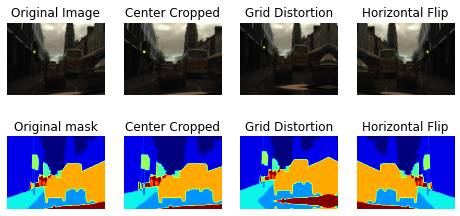

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(441)
plt.title('Original Image')
plt.imshow(img, cmap='jet')
plt. axis('off')
plt.subplot(442)
plt.title('Center Cropped')
plt.imshow(imgcrop, cmap='jet')
plt. axis('off')
plt.subplot(443)
plt.title('Grid Distortion')
plt.imshow(imgdis, cmap='jet')
plt. axis('off')
plt.subplot(444)
plt.title('Horizontal Flip')
plt.imshow(imgaug, cmap='jet')
plt. axis('off')
plt.subplot(445)
plt.title('Original mask')
plt.imshow(mask, cmap='jet')
plt. axis('off')
plt.subplot(446)
plt.title('Center Cropped')
plt.imshow(maskcrop, cmap='jet')
plt. axis('off')
plt.subplot(447)
plt.title('Grid Distortion')
plt.imshow(maskdis, cmap='jet')
plt. axis('off')
plt.subplot(448)
plt.title('Horizontal Flip')
plt.imshow(maskaug, cmap='jet')
plt. axis('off')
plt.savefig("/content/drive/MyDrive/CV Assignment 3/Figures/augmentation.png")
plt.show()


#Data Preprocessing

In [ ]:
#Resizing size images
SIZE_X = 128 
SIZE_Y = 128
n_classes=12 #Number of classes for segmentation

In [ ]:
def ImgAppendAndSort(imagePath, annotationPath):

  # Lists
  annotationList = []
  imagePath =  os.listdir(imagePath)
  annotationPath =  os.listdir(annotationPath)
  #print(annotationPath)

  for image in imagePath:
    #Read image and its annotations from a folder
    img = image[:-4]
    if(img+".png" in annotationPath):
      annotationList.append(img+".png")
      #Store image and annotation in a dataframe
  return imagePath, annotationList

In [ ]:
def listToArray(path, imageList, mask):
  list_im = []
  for x in imageList:
    imgpath = os.path.join(path, x)
    if(mask == True):
      img = cv2.imread(imgpath, 0) 
    else:
      img = cv2.imread(imgpath, cv2.IMREAD_UNCHANGED) 
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    list_im.append(img)
  list_im = np.array(list_im)
  return list_im

In [ ]:
def normalize(x, axis=-1, order=2):
    """Normalizes a Numpy array.
    # Arguments
        x: Numpy array to normalize.
        axis: axis along which to normalize.
        order: Normalization order (e.g. 2 for L2 norm).
    # Returns
        A normalized copy of the array.
    """
    l2 = np.atleast_1d(np.linalg.norm(x, order, axis))
    l2[l2 == 0] = 1
    return x / np.expand_dims(l2, axis)

In [ ]:
path_train_imgs = '/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/images'
path_train_masks = '/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/new_data/masks'
path_test_imgs = '/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/images_prepped_test'
path_test_masks = '/content/drive/MyDrive/CV Assignment 3/A3_Dataset/dataset1/annotations_prepped_test'

In [ ]:
train_img, train_mask = ImgAppendAndSort(path_train_imgs, path_train_masks)

In [ ]:
test_img, test_mask = ImgAppendAndSort(path_test_imgs, path_test_masks)

In [ ]:
len(train_img)

1468

In [ ]:
#All images and masks converted to array
train_img_array = listToArray(path_train_imgs, train_img, False)
train_mask_array = listToArray(path_train_masks, train_mask, True)
test_img_array = listToArray(path_test_imgs, test_img, False)
test_mask_array = listToArray(path_test_masks, test_mask, True)

In [ ]:
train_img_array.shape

(1468, 128, 128, 3)

In [ ]:
test_mask_array.shape

(101, 128, 128)

In [ ]:
#Normalize images
train_images = normalize(train_img_array, axis=1)
test_images = normalize(test_img_array, axis=1 )

In [ ]:
#Expand dimensions of the masks
train_mask = np.expand_dims(train_mask_array, axis=3)
test_mask = np.expand_dims(test_mask_array, axis=3)

In [ ]:
train_mask.shape

(1468, 128, 128, 1)

In [ ]:
train_cat = to_categorical(train_mask, num_classes=n_classes)
test_cat = to_categorical(test_mask, num_classes=n_classes)

In [ ]:
train_cat.shape

(1468, 128, 128, 12)

In [ ]:
test_cat.shape

(101, 128, 128, 12)

Divide train data in train and validation subsets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_cat, test_size = 0.2, random_state = 0)

In [ ]:
print("Train Images:", len(X_train), "Validation Images:", len(X_val), "Test Images", len(test_images))

Train Images: 1174 Validation Images: 294 Test Images 101


In [ ]:
print("Train Masks:", len(y_train), "Validation Masks:", len(y_val), "Test Images", len(test_cat))

Train Masks: 1174 Validation Masks: 294 Test Images 101


#Models

##Model 1 - UNET with VGG-16

Parameters

In [ ]:
#n_classes=12
#Optimizer = Adam
activation='softmax'
batch = 32

In [ ]:
#Loss
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),  tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
BACKBONE1 = 'vgg16'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input and change to the form used by pretrained network
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_val)


# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile('Adam', total_loss, metrics)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
print(model1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

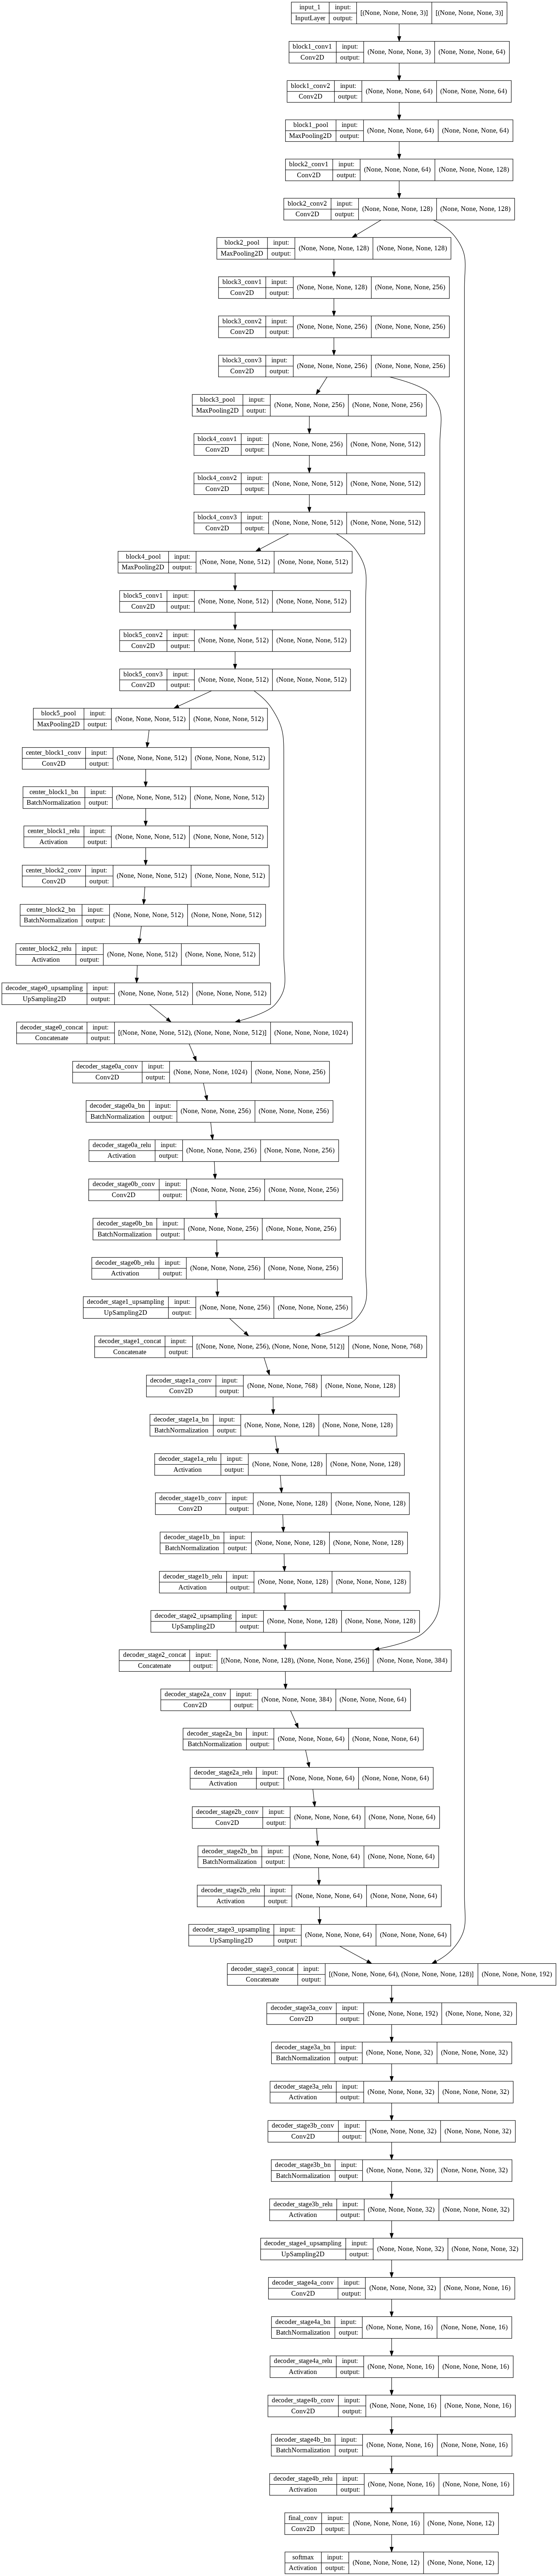

In [ ]:
plot_model(model1, to_file='unet.png', show_shapes=True)

In [ ]:
history1=model1.fit(X_train, 
          y_train,
          batch_size=batch, 
          epochs=20,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/20
37/37 [==============================] - 792s 21s/step - loss: 1.0071 - iou_score: 0.0365 - f1-score: 0.0542 - sensitivity_at_specificity: 0.8604 - specificity_at_sensitivity: 0.8783 - categorical_accuracy: 0.3525 - val_loss: 1.0779 - val_iou_score: 0.0309 - val_f1-score: 0.0528 - val_sensitivity_at_specificity: 0.7546 - val_specificity_at_sensitivity: 0.7599 - val_categorical_accuracy: 0.2523
Epoch 2/20
37/37 [==============================] - 809s 22s/step - loss: 0.9799 - iou_score: 0.0969 - f1-score: 0.1257 - sensitivity_at_specificity: 0.9598 - specificity_at_sensitivity: 0.9704 - categorical_accuracy: 0.5529 - val_loss: 1.1600 - val_iou_score: 0.0144 - val_f1-score: 0.0247 - val_sensitivity_at_specificity: 0.2828 - val_specificity_at_sensitivity: 0.0000e+00 - val_categorical_accuracy: 0.1771
Epoch 3/20
37/37 [==============================] - 796s 22s/step - loss: 0.9705 - iou_score: 0.1193 - f1-score: 0.1536 - sensitivity_at_specificity: 0.9737 - specificity_at_sensit

In [ ]:
model1.save('/content/drive/MyDrive/CV Assignment 3/A3_Dataset/Model/vgg_backbone_20epochs.hdf5')

Metrics

In [ ]:
#Model prediction
y_pred1=model1.predict(test_images)
y_pred1_argmax=np.argmax(y_pred1, axis=-1).astype('int')

In [ ]:
#revoking one hot encoding from test masks
test_cat_revoked = np.argmax(test_cat, axis=-1).astype('int')

Quantitative Measures

In [ ]:
model1 = load_model('/content/drive/MyDrive/CV Assignment 3/A3_Dataset/Model/vgg_backbone_20epochs.hdf5', compile=False)

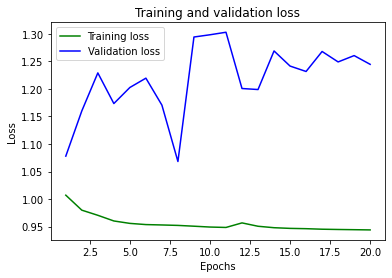

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss VGG16 Backbone')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

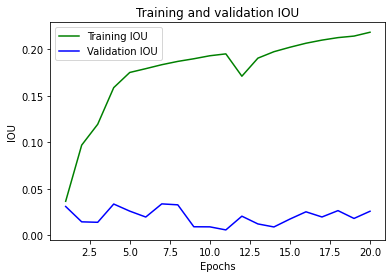

In [ ]:
#plot IOU
acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'g', label='Training IOU')
plt.plot(epochs, val_acc, 'b', label='Validation IOU')
plt.title('Training and validation IOU  VGG16 Backbone')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

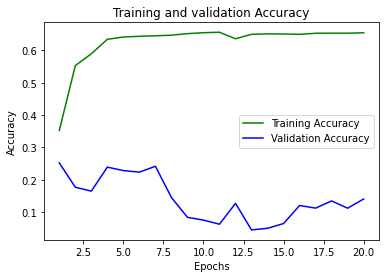

In [ ]:
#accuracy
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy  VGG16 Backbone')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [ ]:
#Model prediction
y_pred1=model1.predict(test_images)
y_pred1_argmax=np.argmax(y_pred1, axis=-1).astype('int')

In [ ]:
#revoking one hot encoding from test masks
test_cat_revoked = np.argmax(test_cat, axis=-1).astype('int')

In [ ]:
#F1 score
print(dice_coef(test_cat, y_pred1))

tf.Tensor(0.044009082, shape=(), dtype=float32)


In [ ]:
a = np.array(y_pred1_argmax)
a = a.flatten()


In [ ]:
b = test_mask_array.flatten()

AUC VGG16


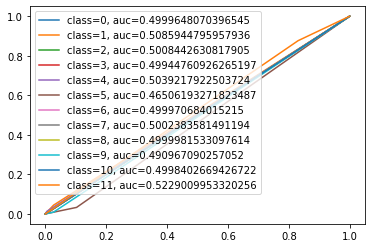

In [ ]:
#ROC Curve, #Sensitivity, #Specificity
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import metrics

def Roc(label, pred):
  dictionaryFPR = {}
  dictionaryTPR = {}
  unique = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  plt.figure(0).clf()
  for x in unique:
    lis = [i for i in unique if i!= x] #remove current class except others

    #Remove other classes except current
    newLabels = [0 if x in lis else 1 for x in label]
    newPred = [0 if x in lis else 1 for x in pred]

    fpr, tpr, thresh = metrics.roc_curve(newLabels, newPred)
    dictionaryFPR[x] = fpr
    dictionaryTPR[x] = tpr 
    auc = metrics.roc_auc_score(newLabels, newPred)
    plt.plot(fpr,tpr,label="class="+str(x)+", auc="+str(auc))
  plt.legend(loc=0)
  return dictionaryFPR, dictionaryTPR

print("AUC VGG16")
dict1, dict2 = Roc(b, a)

In [ ]:
#Specificity
print("Specificity Score per class")
for x, y in dict1.items():
  print(x,':', y[1])

Specificity Score per class
0 : 7.038592069100382e-05
1 : 0.027192881119313495
2 : 0.009400101922213988
3 : 0.0013085414703712475
4 : 0.005160652758571519
5 : 0.10280862370218481
6 : 5.863196957000779e-05
7 : 0.002011426147916225
8 : 3.6933804772832477e-06
9 : 0.02719786391205805
10 : 0.00031946611465558523
11 : 0.830558576220306


In [ ]:
#Sensitivity 
print("Sensitivity Score per class")
for x, y in dict2.items():
  print(x,':', y[1])

Sensitivity Score per class
0 : 0.0
1 : 0.0443818403109008
2 : 0.011088628085795225
3 : 0.00020375999567529804
4 : 0.01300423725931619
5 : 0.03293248913865453
6 : 0.0
7 : 0.002488142446155042
8 : 0.0
9 : 0.009132044426162073
10 : 0.0
11 : 0.8763605668843574


In [ ]:
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_mask[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
#print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[4,3]+ values[4,3])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3]+ values[5,3]+ values[5,3])
class7_IoU = values[6,6]/(values[6,6] + values[6,0] + values[6,1] + values[6,2] + values[6,3]+ values[6,3]+ values[6,3])
class8_IoU = values[7,7]/(values[7,7] + values[7,0] + values[7,1] + values[7,2] + values[7,3]+ values[7,3]+ values[7,3])
class9_IoU = values[8,8]/(values[8,8] + values[8,0] + values[8,1] + values[8,2] + values[8,3]+ values[8,3]+ values[8,3])
class10_IoU = values[9,9]/(values[9,9] + values[9,0] + values[9,1] + values[9,2] + values[9,3]+ values[9,3]+ values[9,3])
class11_IoU = values[10,10]/(values[10,10] + values[10,0] + values[10,1] + values[10,2] + values[10,3]+ values[10,3]+ values[10,3])
class12_IoU = values[11,11]/(values[11,11] + values[11,0] + values[11,1] + values[11,2] + values[11,3]+ values[11,3]+ values[11,3])

print("IoU for class0 is: ", class1_IoU)
print("IoU for class1 is: ", class2_IoU)
print("IoU for class2 is: ", class3_IoU)
print("IoU for class3 is: ", class4_IoU)
print("IoU for class4 is: ", class5_IoU)
print("IoU for class5 is: ", class6_IoU)
print("IoU for class6 is: ", class7_IoU)
print("IoU for class7 is: ", class8_IoU)
print("IoU for class8 is: ", class9_IoU)
print("IoU for class9 is: ", class10_IoU)
print("IoU for class10 is: ", class11_IoU)
print("IoU for class11 is: ", class12_IoU)

Mean IoU = 0.008232933
IoU for class0 is:  0.0
IoU for class1 is:  0.51124585
IoU for class2 is:  0.014466737
IoU for class3 is:  0.009075754
IoU for class4 is:  0.29987454
IoU for class5 is:  0.344141
IoU for class6 is:  0.0
IoU for class7 is:  0.05384939
IoU for class8 is:  0.0
IoU for class9 is:  0.22560975
IoU for class10 is:  0.0
IoU for class11 is:  0.9525327


Qualitative Measures


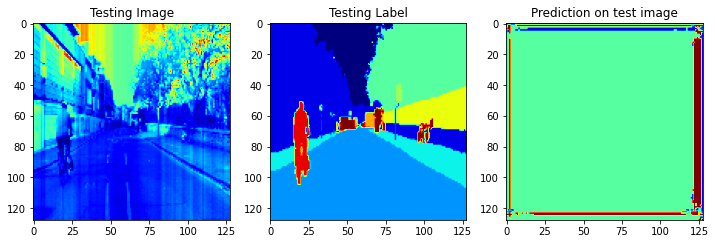

In [ ]:
import random
test_img_number = 20
test_img = test_images[test_img_number]
ground_truth=test_mask_array[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='jet')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

##Model 2: U-Net with DenseNet121 Backbone

In [ ]:
metrics2 = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
BACKBONE2 = 'densenet121'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input and change to the form used by pretrained network
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_val)


# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model2.compile('Adam', total_loss, metrics = metrics2)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
plot_model(model2, to_file='unet2.png', show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.633118 to fit



In [ ]:
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['input_8[0][0]']                
 2D)                            3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_34[0][0]']      
                                64)                                                         

In [ ]:
history2=model2.fit(X_train2, 
          y_train,
          batch_size=batch, 
          epochs=20,
          verbose=1,
          validation_data=(X_test2, y_val))

Epoch 1/20
37/37 [==============================] - 407s 11s/step - loss: 0.9744 - iou_score: 0.1142 - f1-score: 0.1499 - categorical_accuracy: 0.5897 - val_loss: 1.0710 - val_iou_score: 0.0945 - val_f1-score: 0.1263 - val_categorical_accuracy: 0.5154
Epoch 2/20
37/37 [==============================] - 394s 11s/step - loss: 0.9655 - iou_score: 0.1403 - f1-score: 0.1865 - categorical_accuracy: 0.5935 - val_loss: 1.0031 - val_iou_score: 0.1108 - val_f1-score: 0.1483 - val_categorical_accuracy: 0.5423
Epoch 3/20
37/37 [==============================] - 388s 10s/step - loss: 0.9637 - iou_score: 0.1426 - f1-score: 0.1901 - categorical_accuracy: 0.5939 - val_loss: 0.9745 - val_iou_score: 0.1134 - val_f1-score: 0.1451 - val_categorical_accuracy: 0.5919
Epoch 4/20
37/37 [==============================] - 383s 10s/step - loss: 0.9629 - iou_score: 0.1428 - f1-score: 0.1899 - categorical_accuracy: 0.5932 - val_loss: 0.9666 - val_iou_score: 0.1328 - val_f1-score: 0.1744 - val_categorical_accuracy:

In [ ]:
model2.save('/content/drive/MyDrive/CV Assignment 3/A3_Dataset/Model/densenet_backbone_20epochs.hdf5')

Metrics

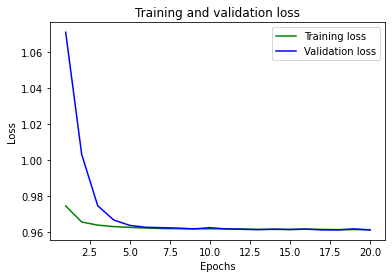

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

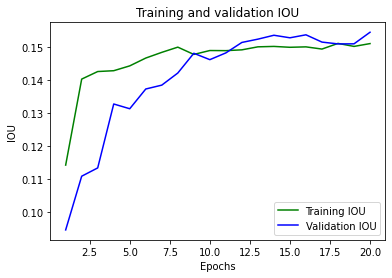

In [ ]:
#plot IOU
acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'g', label='Training IOU')
plt.plot(epochs, val_acc, 'b', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

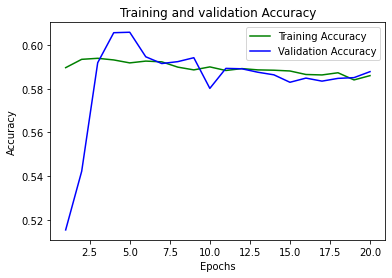

In [ ]:
#accuracy
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model2 = load_model('/content/drive/MyDrive/CV Assignment 3/A3_Dataset/Model/densenet_backbone_20epochs.hdf5', compile=False)

In [ ]:
#Model prediction
y_pred2=model2.predict(test_images)
y_pred2_argmax=np.argmax(y_pred2, axis=-1).astype('int')

In [ ]:
#revoking one hot encoding from test masks
test_cat_revoked = np.argmax(test_cat, axis=-1).astype('int')

In [ ]:
#F1 score
print(dice_coef(test_cat, y_pred2))

tf.Tensor(0.22309898, shape=(), dtype=float32)


In [ ]:
a = np.array(y_pred2_argmax)
a = a.flatten()


In [ ]:
b = test_mask_array.flatten()

AUC DenseNet


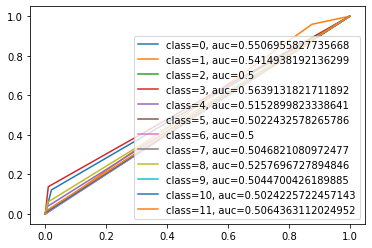

In [ ]:
#ROC Curve, #Sensitivity, #Specificity
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import metrics

def Roc(label, pred):
  dictionaryFPR = {}
  dictionaryTPR = {}
  unique = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  plt.figure(0).clf()
  for x in unique:
    lis = [i for i in unique if i!= x] #remove current class except others

    #Remove other classes except current
    newLabels = [0 if x in lis else 1 for x in label]
    newPred = [0 if x in lis else 1 for x in pred]

    fpr, tpr, thresh = metrics.roc_curve(newLabels, newPred)
    dictionaryFPR[x] = fpr
    dictionaryTPR[x] = tpr 
    auc = metrics.roc_auc_score(newLabels, newPred)
    plt.plot(fpr,tpr,label="class="+str(x)+", auc="+str(auc))
  plt.legend(loc=0)
  return dictionaryFPR, dictionaryTPR

print("AUC DenseNet")
dict1, dict2 = Roc(b, a)

In [ ]:
#Specificity : FPR
print("Specificity Score per class")
for x, y in dict1.items():
  print(x,':', y[1])

Specificity Score per class
0 : 0.020200759238318097
1 : 0.8764674393214349
2 : 1.0
3 : 0.009825987838061177
4 : 0.005936640899880949
5 : 0.0014779569970108735
6 : 1.0
7 : 0.0018324248132024399
8 : 0.00772162745117351
9 : 0.001179207234256792
10 : 0.00039361685693541164
11 : 0.002321300026037279


In [ ]:
#Sensitivity : TPR
print("Sensitivity Score per class")
for x, y in dict2.items():
  print(x,':', y[1])

Sensitivity Score per class
0 : 0.12159192478545171
1 : 0.9594550777486948
2 : 1.0
3 : 0.13765235218043986
4 : 0.03651660556760911
5 : 0.005964472650168295
6 : 1.0
7 : 0.01119664100769769
8 : 0.05926097303014278
9 : 0.010119292472233648
10 : 0.005238761348363916
11 : 0.015193922431027589


In [ ]:
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_mask[:,:,:,0], y_pred2_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
#print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[4,3]+ values[4,3])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3]+ values[5,3]+ values[5,3])
class7_IoU = values[6,6]/(values[6,6] + values[6,0] + values[6,1] + values[6,2] + values[6,3]+ values[6,3]+ values[6,3])
class8_IoU = values[7,7]/(values[7,7] + values[7,0] + values[7,1] + values[7,2] + values[7,3]+ values[7,3]+ values[7,3])
class9_IoU = values[8,8]/(values[8,8] + values[8,0] + values[8,1] + values[8,2] + values[8,3]+ values[8,3]+ values[8,3])
class10_IoU = values[9,9]/(values[9,9] + values[9,0] + values[9,1] + values[9,2] + values[9,3]+ values[9,3]+ values[9,3])
class11_IoU = values[10,10]/(values[10,10] + values[10,0] + values[10,1] + values[10,2] + values[10,3]+ values[10,3]+ values[10,3])
class12_IoU = values[11,11]/(values[11,11] + values[11,0] + values[11,1] + values[11,2] + values[11,3]+ values[11,3]+ values[11,3])

print("IoU for class0 is: ", class1_IoU)
print("IoU for class1 is: ", class2_IoU)
print("IoU for class2 is: ", class3_IoU)
print("IoU for class3 is: ", class4_IoU)
print("IoU for class4 is: ", class5_IoU)
print("IoU for class5 is: ", class6_IoU)
print("IoU for class6 is: ", class7_IoU)
print("IoU for class7 is: ", class8_IoU)
print("IoU for class8 is: ", class9_IoU)
print("IoU for class9 is: ", class10_IoU)
print("IoU for class10 is: ", class11_IoU)
print("IoU for class11 is: ", class12_IoU)

Mean IoU = 0.052232165
IoU for class0 is:  0.11077166
IoU for class1 is:  0.42743614
IoU for class2 is:  0.0
IoU for class3 is:  0.13918877
IoU for class4 is:  0.03290272
IoU for class5 is:  0.005975748
IoU for class6 is:  0.0
IoU for class7 is:  0.011553274
IoU for class8 is:  0.06050687
IoU for class9 is:  0.010939168
IoU for class10 is:  0.0054582343
IoU for class11 is:  0.016948313


Qualitative Results

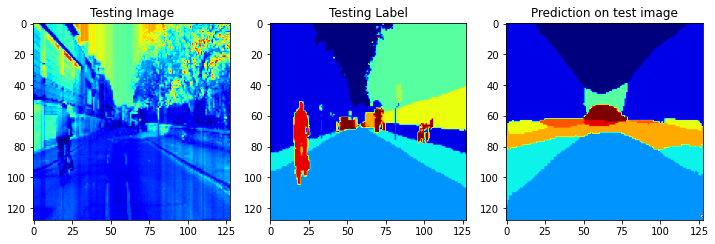

In [ ]:
import random
test_img_number = 20
test_img = test_images[test_img_number]
ground_truth=test_mask_array[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input2(test_img_input)

test_pred1 = model2.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='jet')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()